In [1]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pandas import DataFrame
import numpy as np 
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
#from imblearn import *

#from imblearn.over_sampling import SMOTE, ADASYN
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import scipy as sp

import copy

import sys

In [6]:
rawdata = pd.read_csv("train.csv")

In [7]:
target = rawdata.groupby("PlayId")["Yards"].aggregate("mean")
del rawdata["Yards"]

## 전체 데이터 구조

In [8]:
rawdata.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [9]:
# 컬럼명 탐색

rawdata.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff', 'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'], dtype='object')

In [10]:
# 한번의 플레이당(즉 동일 PlayID)당 22개의 선수들이 하나로 묶여서 경기를 진행
# 즉, 분석을 위해선 22개 행의 단위로 GROUP을 지어서 분석을 실시할 필요가 있음

rawdata[rawdata["PlayId"] == rawdata["PlayId"][0]][["GameId","PlayId","Team","DisplayName","TimeHandoff","Position"]]

,GameId,PlayId,Team,DisplayName,TimeHandoff,Position
0,2017090700,20170907000118,away,Eric Berry,2017-09-08T00:44:06.000Z,SS
1,2017090700,20170907000118,away,Allen Bailey,2017-09-08T00:44:06.000Z,DE
2,2017090700,20170907000118,away,Justin Houston,2017-09-08T00:44:06.000Z,DE
3,2017090700,20170907000118,away,Derrick Johnson,2017-09-08T00:44:06.000Z,ILB
4,2017090700,20170907000118,away,Ron Parker,2017-09-08T00:44:06.000Z,FS
5,2017090700,20170907000118,away,Dee Ford,2017-09-08T00:44:06.000Z,DE
6,2017090700,20170907000118,away,Terrance Mitchell,2017-09-08T00:44:06.000Z,CB
7,2017090700,20170907000118,away,Phillip Gaines,2017-09-08T00:44:06.000Z,CB
8,2017090700,20170907000118,away,Daniel Sorensen,2017-09-08T00:44:06.000Z,SS
9,2017090700,20170907000118,away,Marcus Peters,2017-09-08T00:44:06.000Z,CB


(array([8.5800e+02, 1.9151e+04, 2.5630e+03, 4.0800e+02, 9.3000e+01,
       4.6000e+01, 2.3000e+01, 2.1000e+01, 3.0000e+00, 5.0000e+00]), array([-14. ,  -2.7,   8.6,  19.9,  31.2,  42.5,  53.8,  65.1,  76.4,
        87.7,  99. ]), <a list of 10 Patch objects>)
23171


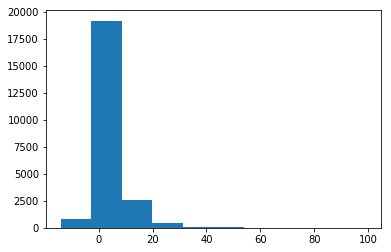

In [11]:
# 타겟변수 분포

print(plt.hist(target))
print(target.count())

In [12]:
# 연속형 변수들의 summary
# 표준편차, max값을 확인해볼 때 극단적인 이상치는 없는 것으로 추정된다.

rawdata.iloc[:,2:].describe()

,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayerWeight,Week,Temperature,Humidity
count,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,461230.000000,503602.000000
mean,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,253.554388,9.096370,60.436442,55.646062
std,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,48.367386,5.000984,17.570291,25.430976
min,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,153.000000,1.000000,9.000000,0.000000
25%,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,210.000000,5.000000,48.000000,43.000000
50%,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,245.000000,9.000000,62.000000,59.000000
75%,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,305.000000,14.000000,73.000000,71.000000
max,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,380.000000,17.000000,97.000000,100.000000


In [13]:
IQR = rawdata.describe().loc["75%",:] - rawdata.describe().loc["25%",:]

In [14]:
lower_bound = rawdata.describe().loc["25%"] - 1.5 * IQR
upper_bound = rawdata.describe().loc["75%"] + 1.5 * IQR

### 3IQR을 넘어가는 이상치의 갯수. 박스플롯을 그릴 수 없으므로 대안적으로 데이터프레임을 선택

In [16]:
(rawdata.loc[:,(rawdata.dtypes != "object").values] < lower_bound).aggregate(lambda x : x.value_counts(),axis="index")

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayerWeight,Week,Temperature,Humidity
False,509762.0,509762.0,509762.0,495044,509762.0,509762.0,509762.0,509762.0,509762.0,428376,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0,420310,509718,509762.0,509762.0,507496,464508
True,NaN,NaN,NaN,14718,NaN,NaN,NaN,NaN,NaN,81386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89452,44,NaN,NaN,2266,45254


In [19]:
(rawdata.loc[:,(rawdata.dtypes != "object").values] > upper_bound).aggregate(lambda x : x.value_counts(),axis="index")

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayerWeight,Week,Temperature,Humidity
False,509762.0,509762.0,509762.0,495625,507290,504107,508233,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0,505560,498828,502304,502920,509762.0,509762.0,509762.0,509762.0,509762.0,509762.0
True,NaN,NaN,NaN,14137,2472,5655,1529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4202,10934,7458,6842,NaN,NaN,NaN,NaN,NaN,NaN


## 선수별 포지션 일람
### 각 변수별로 *22의 와이드폼으로 펼칠 때, 포지션별로 개별 할당이 가능한지 탐색

In [8]:
rawdata["Position"].unique()

array(['SS', 'DE', 'ILB', 'FS', 'CB', 'DT', 'WR', 'TE', 'T', 'QB', 'RB',
       'G', 'C', 'OLB', 'NT', 'FB', 'MLB', 'LB', 'OT', 'OG', 'HB', 'DB',
       'S', 'DL', 'SAF'], dtype=object)

In [9]:
# 몇몇 선수들은 하나 이상의 포지션을 맡은 것으로 보인다. 12만큼의 중복된 인원이 존재한다.

print("전체 선수들의 수")
print(len(rawdata["DisplayName"].unique()))
print("포지션 별 선수들의 수")
print(len(rawdata.groupby("DisplayName")["Position"].value_counts()))

전체 선수들의 수
2230
포지션 별 선수들의 수
2242


In [10]:
# 중복 포지션을 갖고있는 선수들 골라내기

temp = DataFrame(rawdata.groupby("DisplayName")["Position"].value_counts()).unstack().unstack().unstack()

for i in range(0,len(temp.T)):
    if temp.isnull().iloc[:,i].value_counts()[0] != 1:
        print(temp.iloc[:,i].name)
        print(temp.iloc[:,i].Position.dropna().index.values)

Andre Smith
['LB' 'T']
Brandon Marshall
['ILB' 'WR']
Brandon Williams
['CB' 'DT' 'TE']
Chris Thompson
['RB' 'WR']
Isaiah Johnson
['DB' 'S']
Joe Thomas
['ILB' 'OT']
Kyle Fuller
['C' 'CB']
Marcus Williams
['CB' 'FS']
Michael Bennett
['DE' 'DT']
Michael Thomas
['SS' 'WR']
Nick Williams
['DT' 'WR']


In [11]:
# 한 번의 경기엔 여러개의 중복 포지션들이 존재함
# 선수의 수 = 22명
# 포지션의 수 = 13

rawdata[rawdata["PlayId"] == rawdata["PlayId"][1]]["Position"].value_counts()

CB     3
WR     3
DE     3
T      2
SS     2
G      2
ILB    1
TE     1
C      1
QB     1
RB     1
DT     1
FS     1
Name: Position, dtype: int64

# 경기 시작후 선수들의 위치 현황

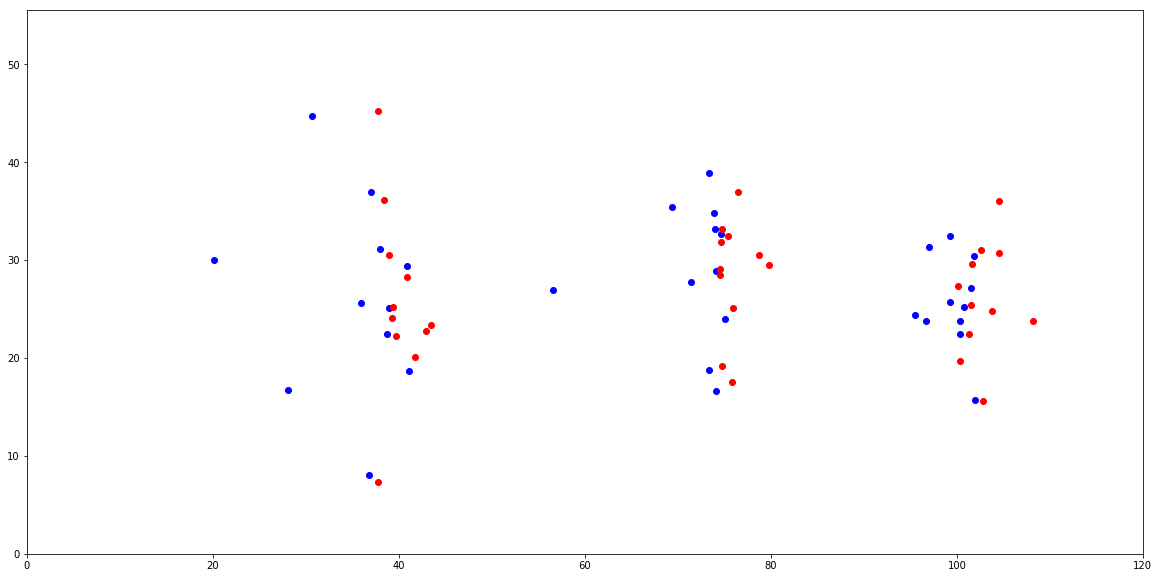

In [25]:
x_away_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "away"]["X"]
y_away_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "away"]["Y"]

x_home_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "home"]["X"]
y_home_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "home"]["Y"]

# ======================================================================================================

x_away_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "away"]["X"]
y_away_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "away"]["Y"]

x_home_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "home"]["X"]
y_home_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "home"]["Y"]

# =====================================================================================================

x_away_3 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[10]][rawdata["Team"] == "away"]["X"]
y_away_3 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[10]][rawdata["Team"] == "away"]["Y"]

x_home_3 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[10]][rawdata["Team"] == "home"]["X"]
y_home_3 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[10]][rawdata["Team"] == "home"]["Y"]

plt.figure(figsize=(20,10))

plt.xlim(0,120)
plt.ylim(0,55.5)
# 첫 번째 경기
plt.scatter(x = x_away_1, y = y_away_1,c="b")
plt.scatter(x = x_home_1, y = y_home_1,c="r")
# 두 번째 경기
plt.scatter(x = x_away_2, y = y_away_2,c="b")
plt.scatter(x = x_home_2, y = y_home_2,c="r")
# 세 번째 경기
plt.scatter(x = x_away_3, y = y_away_3, c = "b")
plt.scatter(x = x_home_3, y = y_home_3, c = "r")

plt.show()

# 매 경기마다 시작위치가 달라진다

In [15]:
# 시계열적 특성 = 선수는 갈수록 지칠것이다
# 매 iteration 자체의 특성 = 시작 위치, 속력, 각속도 등..

# 시작 위치와 골라인간의 직선거리(L2 Norm)을 고려(특성 엔지니어링)

# 두 개를 모두 고려한 모델을 생각해보자

# 데이터 전처리 - 카테고리 변수의 변환

# 데이터 전처리 - 결측치 처리

In [16]:
print ("결측치 표시기")
missmap = rawdata.isnull().sum().to_frame().sort_values(0, ascending = False)
missmap[missmap[0] != 0]

결측치 표시기


,0
WindDirection,80234
WindSpeed,67430
Temperature,48532
GameWeather,43648
StadiumType,32934
FieldPosition,6424
Humidity,6160
OffenseFormation,110
DefendersInTheBox,66
Orientation,18


### 과연 결측치들은 어느 변수와 가장 큰 연관성을 갖고 있을까?

## 바람 방향(WindDirection)

In [27]:
rawdata.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff', 'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'], dtype='object')

In [37]:
temp = rawdata.groupby("HomeTeamAbbr")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 각 홈팀 이름별로 nan값만 발생하는 경우가 있다. 이들의 홈구장의 환경과 연관이 있는걸까?

HomeTeamAbbr
ARI                                  [nan, NE, SE, N, W]
ATL                                [NW, nan, ESE, E, SW]
CLE           [East, SE, West, South, N, SW, nan, North]
DAL                   [nan, North, North/Northwest, SSE]
DEN    [SouthWest, E, NorthEast, North, Northeast, So...
DET                                                [nan]
KC     [Northeast, South Southeast, Northwest, South ...
LA                    [SW, nan, W, North, ESE, NNW, WSW]
MIN                                                [nan]
NE           [SW, NE, N, SE, WNW, North, West, SSW, nan]
NYJ     [NE, NNE, WNW, East, South, NW, nan, N, SW, NNW]
SF     [Northwest, West-Southwest, NW, West, Southeas...
WAS    [North, nan, South, ESE, NE, ENE, WNW, East, S...
Name: WindDirection, dtype: object

In [38]:
temp = rawdata.groupby("VisitorTeamAbbr")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 원정팀과 바람의 결측값과는 상관이 없다.

VisitorTeamAbbr
ARI     [nan, SSW, W, NW, North, South, N, SW, N-NE, SE]
ATL    [SE, nan, NE, East, ENE, E, NNE, WNW, NNW, Fro...
BAL    [SE, WNW, nan, WSW, W-NW, From SW, N, S, North...
BUF    [North, nan, SSE, South, W, South Southwest, N...
CAR    [Northwest, N, nan, S, NNW, NW, NE, From NNE, ...
CHI              [NE, SW, s, N, NW, SSW, nan, E, 8, NNW]
CIN    [S, SE, From S, NNE, SSW, North, nan, NW, NE, ...
CLE    [ESE, ENE, N, nan, E, WSW, WNW, From W, NW, W,...
DAL    [SouthWest, nan, NW, ESE, West, NNW, East Nort...
DET       [ENE, nan, SE, SW, WNW, N, S, NW, SSW, W, NNE]
GB     [NW, nan, WSW, From WSW, SW, SSW, NE, West, So...
HOU    [ENE, NE, nan, Southeast, East, SE, NW, SW, So...
JAX    [NNE, From SW, S, West, nan, Northeast, NE, WS...
KC     [SW, W, NW, nan, WNW, NorthEast, From ESE, Nor...
LA     [West-Southwest, nan, NE, ENE, S, WSW, SSE, No...
LAC    [SouthWest, WSW, NNE, SE, NE, nan, South, N, S...
MIA    [W, NE, nan, West, NNE, WNW, NW, East, S, NNW,...
MIN    [From S,

In [41]:
temp = rawdata.groupby("Turf")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 아니 이건 또 왜 같은 잔디종류를 여러개로 나누고 그래

Turf
Artificial       [NNE, nan, SSW, ENE, N, ESE, NW, S, NE, WSW, N...
Field Turf             [SW, nan, NE, N, SE, WNW, North, West, SSW]
Field turf                                                   [nan]
FieldTurf        [S, NE, NNE, NNW, WNW, East, ENE, South, E, NW...
FieldTurf 360                                            [NW, nan]
FieldTurf360                                     [nan, ESE, E, SW]
Grass            [SE, East, NE, North, SW, SouthWest, NW, From ...
Natural Grass    [Northwest, ESE, North, Northeast, NE, South, ...
Natural grass                         [West-Southwest, NW, N, nan]
natural grass                                                [nan]
Name: WindDirection, dtype: object

In [36]:
temp = rawdata.groupby("FieldPosition")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 필드포지션과는 상관이 없다.

FieldPosition
ARZ    [nan, SSW, W, NW, North, NE, South, SE, N, SW,...
ATL    [SE, NW, nan, NE, East, ENE, E, NNE, WNW, NNW,...
BLT    [SE, ESE, North, WNW, s, nan, West, WSW, W-NW,...
BUF    [NNE, North, W, nan, SSE, s, NE, South, WSW, S...
CAR    [Northwest, North, NNE, N, nan, ENE, S, NNW, N...
CHI    [SE, NE, S, SW, s, N, WSW, WNW, NW, SSW, nan, ...
CIN    [SE, ENE, S, SSE, From S, NNW, NNE, SSW, North...
CLV    [East, ESE, ENE, SE, West, N, South, nan, E, W...
DAL    [nan, SouthWest, NW, ESE, North, West, NNW, Ea...
DEN    [SouthWest, W, E, NorthEast, Northwest, SE, No...
DET       [nan, ENE, SE, SW, WNW, N, S, NW, SSW, W, NNE]
GB     [S, NW, SW, nan, W, WSW, W-NW, From WSW, SE, S...
HST    [NNE, ENE, NE, N, NW, SSW, nan, North, Southea...
JAX    [NNE, NW, SE, From SW, NE, S, West, nan, North...
KC     [SW, Northeast, W, South Southeast, NW, Northw...
LA     [SW, West-Southwest, nan, NE, W, ENE, North, S...
LAC    [SouthWest, W, S, WSW, NNE, SE, NE, nan, NNW, ...
MIA    [W, NE, 13

In [18]:
temp = rawdata.groupby("GameWeather")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

## 구름이 끼거나, 실내 경기장인 경우 바람 방향은 결측치이다.

GameWeather
Clear                         [Northwest, NE, NW, nan, NNW, South Southeast,...
Clear skies                                              [nan, North/Northwest]
Cloudy                        [Northeast, W, SW, ENE, E, West, ESE, WSW, Fro...
Controlled Climate                                                        [nan]
Hazy                                                               [S, NE, nan]
Indoor                                                                    [nan]
Indoors                                                      [nan, E, WNW, ESE]
N/A (Indoors)                                                             [nan]
N/A Indoor                                                                [nan]
Partly Cloudy                 [NW, SouthWest, ESE, N, SSE, West, SW, NorthEa...
Sunny                         [SE, East, NNE, NE, North, SW, From S, South, ...
T: 51; H: 55; W: NW 10 mph                                                [nan]
Name: WindDirection, dtype: 

In [19]:
temp = rawdata.groupby("StadiumType")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 마찬가지로 실내돔인 경우 바람방향은 결측치이다.

StadiumType
Closed Dome                                                           [nan]
Dome                                                 [nan, NE, SE, N, E, W]
Dome, closed                                                          [nan]
Domed, Open                                                           [nan]
Domed, closed                                                         [nan]
Indoor                                          [nan, North/Northwest, SSE]
Indoor, Roof Closed                                                   [nan]
Indoors                          [nan, NNE, SE, N, SW, NE, WSW, WNW, NW, E]
Outdoor                   [SW, SE, East, S, Northwest, SouthWest, ENE, E...
Outdoor Retr Roof-Open                                                [nan]
Outdoors                  [NNE, NE, North, From S, SE, W, From SW, ENE, ...
Outside                                                               [nan]
Name: WindDirection, dtype: object

In [20]:
temp = rawdata.groupby("WindSpeed")["WindDirection"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# calm이거나 0인경우에 바람 방향은 결측치이다.

WindSpeed
0.0                                        [nan, SSE, SE]
1                                       [From S, SW, nan]
5.0     [North, SouthWest, ENE, NNE, East, SE, NE, Wes...
0                                                [nan, N]
Calm                                                [nan]
Name: WindDirection, dtype: object

## StadiumType 결측값

In [61]:
temp = rawdata.groupby("Stadium")["StadiumType"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# StubHub Center는 스타디움 유형이 결측처리 되어있다.

Stadium
MetLife Stadium              [nan, Outdoor, Outdoors]
StubHub Center                                  [nan]
TIAA Bank Field    [Open, Outdoor, nan, Cloudy, Bowl]
Name: StadiumType, dtype: object

In [63]:
temp = rawdata.groupby("HomeTeamAbbr")["StadiumType"]
nan_compromised = temp.value_counts(dropna=False).unstack().iloc[:,0].isnull() == False
nan_compromised = nan_compromised[nan_compromised]
temp.unique()[nan_compromised.index]

# 홈팀 중 NYG는 nan값밖엔 없다.

HomeTeamAbbr
JAX    [Open, Outdoors, Outdoor, nan, Cloudy, Bowl]
LAC                                 [nan, Outdoors]
NYG                                           [nan]
Name: StadiumType, dtype: object

# 데이터 전처리 - 와이드폼 전환

In [38]:
rawdata_cat = rawdata.copy()
rawdata_cat = rawdata_cat.drop(columns="GameId")

In [39]:
rawdata_QB = rawdata_cat[rawdata_cat["Position"] == "QB"].copy()
rawdata_cat = rawdata_cat[rawdata_cat["Position"] != "QB"].copy()

In [49]:
# 왜 22가 나오는거지?

(rawdata_cat.groupby(['PlayId']).cumcount() + 1).value_counts()

11    23171
10    23171
2     23171
3     23171
4     23171
5     23171
6     23171
7     23171
8     23171
9     23171
1     23171
12    23171
13    23171
14    23171
15    23171
16    23171
17    23171
18    23171
19    23171
20    23171
21    23050
22        2
dtype: int64

In [54]:
## 22가 존재하는, 즉 QB가 정상적으로 제거되지 않은 PlayID들

rawdata_cat[rawdata_cat["row_number"] == 22]["PlayId"]

42855     20170924102908
144429    20171112080136
Name: PlayId, dtype: int64

In [128]:
rawdata_cat.loc[0:22,"Position"].value_counts().sort_index()

C      1
CB     3
DE     3
DT     1
FS     1
G      2
ILB    1
RB     1
SS     3
T      2
TE     1
WR     3
Name: Position, dtype: int64

In [129]:
rawdata_cat[rawdata_cat["PlayId"] == 20170924102908]["Position"].value_counts().sort_index()

C      1
CB     2
DE     1
DT     2
FS     1
G      2
LB     1
MLB    2
OLB    1
RB     2
SS     1
T      2
TE     3
WR     1
Name: Position, dtype: int64

In [ ]:
## QB가 존재하는 경우엔 ILB가, 그렇지 않은 경우엔 MLB과 OLB로 구분되어 있다.

In [136]:
rawdata[0:22]["Position"].value_counts().sort_index()

C      1
CB     3
DE     3
DT     1
FS     1
G      2
ILB    1
QB     1
RB     1
SS     2
T      2
TE     1
WR     3
Name: Position, dtype: int64

In [135]:
rawdata[rawdata["PlayId"] == 20170924102908]["Position"].value_counts().sort_index()

C      1
CB     2
DE     1
DT     2
FS     1
G      2
LB     1
MLB    2
OLB    1
RB     2
SS     1
T      2
TE     3
WR     1
Name: Position, dtype: int64

In [44]:
rawdata_cat['row_number'] = rawdata_cat.groupby(['PlayId']).cumcount() + 1

In [45]:
new_df = rawdata_cat.pivot_table(index=['PlayId'], columns=['row_number'], values=rawdata_cat.columns)

In [ ]:
## modeling
## 우선 22개 행의 변수들을 하나의 행인 WideForm으로 만든다
## 즉, 하나의 변수당 22개의 열들이 생긴다(X_1, X_2....X_22, Y_1,y_2,....Y_22 등)